# Raw compositing 

## Load package

In [1]:
import numpy as np;
import netCDF4 as nc;

from joblib     import Parallel, delayed;

from matplotlib import gridspec;
from matplotlib import pyplot as plt;
from matplotlib.colors import TwoSlopeNorm;
from mpl_toolkits.axes_grid1.inset_locator import inset_axes;

## Functions

### Load data

In [2]:
def load_data(
    path: str,
    var : str,
    lim : list[int],
) -> np.ndarray:
    with nc.Dataset(f"{path}{var}.nc", "r") as f:
        data = f.variables[var][:, :, lim, :].mean(axis=2)
        return var, data

### Vertical integrated

In [3]:
def vert_int(
        data: np.ndarray,
        lev : np.ndarray
) -> np.ndarray:
    
    data_ave: np.ndarray = (data[1:] + data[:-1])/2
    data_int: np.ndarray = np.sum(
        np.multiply(data_ave, np.diff(lev)[:, None]*100),
        axis = 0
    ) / np.sum(np.diff(lev)*100)
    
    return data_int

## Load data

In [4]:
# experiment name
exp_name: str = "NSC"

# load select events
sel_path: str = f"/home/b11209013/2024_Research/MPAS/Composite/Q1_event_sel/Q1_sel/{exp_name}.npy";

lon_ref, time_ref = np.load(sel_path);

# load MPAs soruced data
path    : str       = f"/work/b11209013/2024_Research/MPAS/merged_data/{exp_name}/";

var_list: list[str] = [
    "q1", "qv", "theta",
    "rthcuten", "rthratenlw", "rthratensw"
];

## load dimension
dims: dict[str, np.ndarray] = dict()

with nc.Dataset(f"{path}{var_list[0]}.nc", "r") as f:
    for key in f.dimensions.items():
        dims[key[0]] = f.variables[key[0]][:];

### limit the latitude within -5~5
lat_lim: list[int] = np.where((dims["lat"] >= -5.) & (dims["lat"] <= 5.))[0]
dims["lat"] = dims["lat"][lat_lim]

## load variables
data: dict[str, np.ndarray] = dict(
    Parallel(n_jobs=-1)(
        delayed(load_data)(path, var, lat_lim)
        for var in var_list
    )
)

## Unit conversion

In [5]:
theta2t: np.ndarray = (1000/dims["lev"])[None, :, None] ** (-287.5/1004.5);

data_convert: dict[str, np.ndarray] = dict(
    t  = data["theta"] * theta2t,              # θ -> temperature
    q1 = data["q1"] * 85400/1004.5,            # J/kg/s -> K/day 
    qv = data["qv"] * 1000,                    # kg/kg -> g/kg
    cu = data["rthcuten"] * theta2t * 86400,   # K/s -> K/day
    lw = data["rthratenlw"] * theta2t * 86400, # K/s -> day
    sw = data["rthratensw"] * theta2t * 86400, # K/s -> K/day
);

data_convert = {
    var: data_convert[var] - data_convert[var].mean(axis=(0, 2))[None, :, None]
    for var in data_convert.keys()
};

## Event Selecting

### Time ticks setting

In [6]:
time_itv: np.ndarray = np.array([
    np.linspace(t_ref-12, t_ref+12, 25, dtype=int)
    for t_ref in time_ref
]);
# shape: (event, time_interval)

time_ticks = np.linspace(-3, 3, 25);

### Event selection

In [7]:
data_sel: dict[str, np.ndarray] = {
    var : np.array([
        data_convert[var][time_itv[i], :, lon_ref[i]]
        for i in range(len(lon_ref))
    ]).mean(axis=0).T
    for var in data_convert.keys()
};

## Vertical integrated heating profile

In [8]:
data_vint: dict[str, np.ndarray] = {
    key: vert_int(data_sel[key], dims['lev'])
    for key in data_sel.keys()
};



## Plot 

### Plot setting

In [9]:
plt.rcParams.update({
    'font.size': 10,
    'figure.titlesize': 16,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'font.family': 'serif',
})


### Plotting

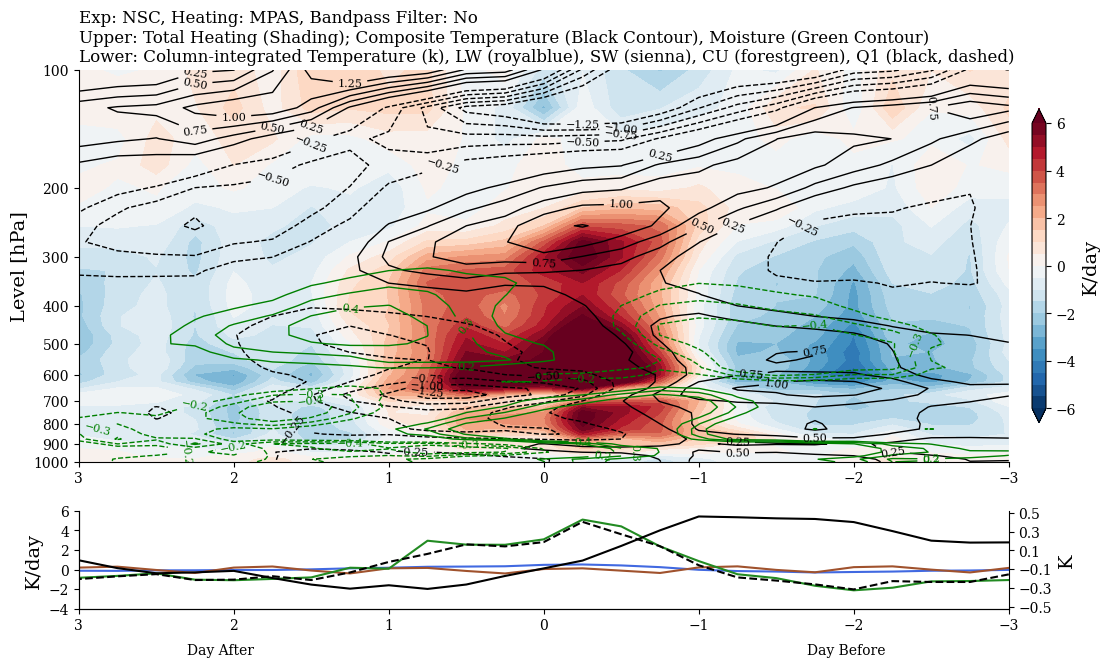

In [10]:
fig = plt.figure(figsize=(12, 7));
gs  = gridspec.GridSpec(2, 1, height_ratios=[4, 1]);

# ================= #

ax1 = plt.subplot(gs[0]);

cr1 = plt.contourf(
    time_ticks, dims["lev"],
    data_sel['q1'],
    cmap="RdBu_r",
    levels=np.linspace(-6, 6, 25),
    extend="both",
    norm=TwoSlopeNorm(vcenter=0)
);
c1 = ax1.contour(
    time_ticks, dims['lev'], data_sel['t'],
    colors='k',
    linewidths=1,
    levels=[-1.25, -1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1, 1.25]
);
crqv = plt.contour(
    time_ticks, dims['lev'], data_sel['qv'],
    levels=[-0.4, -0.3, -0.2,  0.2, 0.3, 0.4],
    colors='green', linewidths=1
);

plt.gca().spines["top"].set_visible(False);
plt.gca().spines["right"].set_visible(False);
plt.yscale("log")
ax1.set_xticks(np.linspace(-3, 3, 7));
ax1.set_yticks(np.linspace(1000, 100, 10), np.linspace(1000, 100, 10, dtype=int))
plt.gca().invert_yaxis();
ax1.set_ylabel("Level [hPa]")
ax1.set_title(f'Exp: {exp_name}, Heating: MPAS, Bandpass Filter: No\n\
Upper: Total Heating (Shading); Composite Temperature (Black Contour), Moisture (Green Contour)\n\
Lower: Column-integrated Temperature (k), LW (royalblue), SW (sienna), CU (forestgreen), Q1 (black, dashed)',
fontsize=12, loc='left')

plt.clabel(c1, inline=True, fontsize=8)
plt.clabel(crqv, inline=True, fontsize=8)

# ================= #

ax2 = plt.subplot(gs[1], sharex=ax1)
ax2.plot(
    time_ticks, data_vint['lw'],  
    color='royalblue',
    label='LW'
)
ax2.plot(
    time_ticks, data_vint['sw'],
    color='sienna',
    label='SW'
)
ax2.plot(
    time_ticks, data_vint['cu'],
    color='forestgreen',
    label='Cu'
)
ax2.plot(
    time_ticks, data_vint['q1'],
    color='k',
    linestyle='--',
    label='Q1'
)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
ax2.set_xticks(np.linspace(-3, 3, 7))
ax2.set_yticks([-4, -2, 0, 2, 4, 6])
ax2.set_xlim(-3, 3)
ax2.set_ylim(-4, 6)
ax2.set_ylabel('K/day')
plt.gca().invert_xaxis();

ax3 = ax2.twinx()
ax3.plot(
    time_ticks, data_vint['t'],
    color='k', 
    label='T'
)
plt.gca().spines['top'].set_visible(False)
ax3.set_ylabel('K')
ax3.set_yticks(np.linspace(-0.5, 0.5, 6))
ax3.set_ylim(-0.52, 0.52)

plt.text(2.3, -1, 'Day After')
plt.text(-1.7, -1, 'Day Before')

cax = inset_axes(
    ax1, width="1.5%", height="80%", loc="center right",
    bbox_to_anchor=(0.04, 0, 1, 1),
    bbox_transform=ax1.transAxes, borderpad=0
);
cbar = fig.colorbar(
    cr1, cax=cax,
    ax=[ax1, ax2],
    location="right",  label="K/day"
)
cbar.set_ticks(np.linspace(-6, 6, 7, dtype=int))
plt.savefig(f"/home/b11209013/2024_Research/MPAS/Composite/raw_composite/Raw_comp_image/MPAS_sourced/{exp_name}_raw_comp.png", dpi=300)
plt.show()
plt.close()

### LW composite

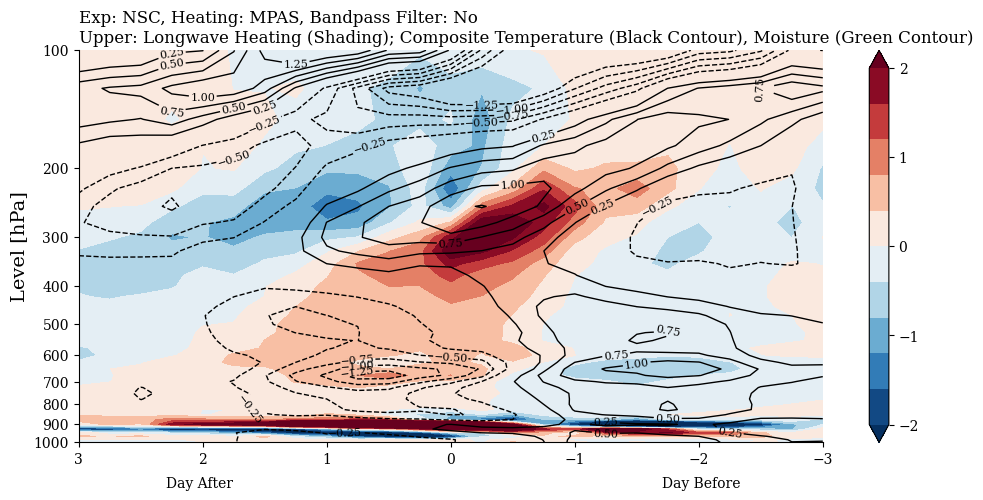

In [11]:
fig = plt.figure(figsize=(12, 7));

# ================= #

ax1 = plt.subplot(gs[0]);

cr1 = plt.contourf(
    time_ticks, dims["lev"],
    data_sel['lw'],
    cmap="RdBu_r",
    levels=np.linspace(-2, 2, 11),
    extend="both",
    norm=TwoSlopeNorm(vcenter=0)
);
c1 = ax1.contour(
    time_ticks, dims['lev'], data_sel['t'],
    colors='k',
    linewidths=1,
    levels=[-1.25, -1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1, 1.25]
);

plt.gca().spines["top"].set_visible(False);
plt.gca().spines["right"].set_visible(False);
plt.yscale("log")
ax1.set_xticks(np.linspace(-3, 3, 7));
ax1.set_yticks(np.linspace(1000, 100, 10), np.linspace(1000, 100, 10, dtype=int))
plt.gca().invert_xaxis()
plt.gca().invert_yaxis();
ax1.set_ylabel("Level [hPa]")
ax1.set_title(f'Exp: {exp_name}, Heating: MPAS, Bandpass Filter: No\n\
Upper: Longwave Heating (Shading); Composite Temperature (Black Contour), Moisture (Green Contour)',
fontsize=12, loc='left')

plt.clabel(c1, inline=True, fontsize=8)
cb = plt.colorbar(cr1, ax=ax1)
cb.set_ticks(np.linspace(-2, 2, 5))
plt.text(2.3, 1300, 'Day After')
plt.text(-1.7, 1300, 'Day Before')
plt.savefig(f"/home/b11209013/2024_Research/MPAS/Composite/raw_composite/Raw_comp_image/MPAS_sourced/{exp_name}_lw_raw_comp.png", dpi=300)
plt.show()
plt.close()

### SW composite

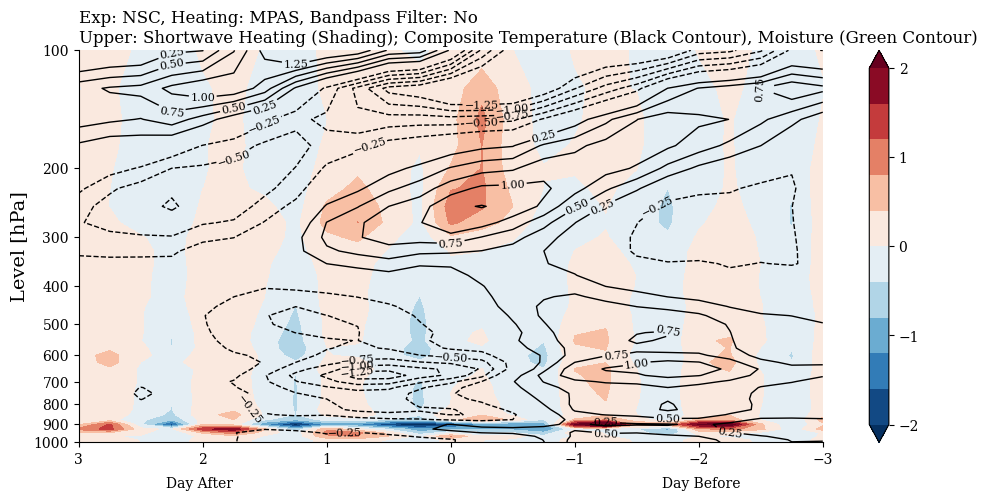

In [12]:
fig = plt.figure(figsize=(12, 7));

# ================= #

ax1 = plt.subplot(gs[0]);

cr1 = plt.contourf(
    time_ticks, dims["lev"],
    data_sel['sw'],
    cmap="RdBu_r",
    levels=np.linspace(-2, 2, 11),
    extend="both",
    norm=TwoSlopeNorm(vcenter=0)
);
c1 = ax1.contour(
    time_ticks, dims['lev'], data_sel['t'],
    colors='k',
    linewidths=1,
    levels=[-1.25, -1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1, 1.25]
);

plt.gca().spines["top"].set_visible(False);
plt.gca().spines["right"].set_visible(False);
plt.yscale("log")
ax1.set_xticks(np.linspace(-3, 3, 7));
ax1.set_yticks(np.linspace(1000, 100, 10), np.linspace(1000, 100, 10, dtype=int))
plt.gca().invert_xaxis()
plt.gca().invert_yaxis();
ax1.set_ylabel("Level [hPa]")
ax1.set_title(f'Exp: {exp_name}, Heating: MPAS, Bandpass Filter: No\n\
Upper: Shortwave Heating (Shading); Composite Temperature (Black Contour), Moisture (Green Contour)',
fontsize=12, loc='left')

plt.clabel(c1, inline=True, fontsize=8)
cb = plt.colorbar(cr1, ax=ax1)
cb.set_ticks(np.linspace(-2, 2, 5))
plt.text(2.3, 1300, 'Day After')
plt.text(-1.7, 1300, 'Day Before')
plt.savefig(f"/home/b11209013/2024_Research/MPAS/Composite/raw_composite/Raw_comp_image/MPAS_sourced/{exp_name}_sw_raw_comp.png", dpi=300)
plt.show()
plt.close()

### Radiative composite

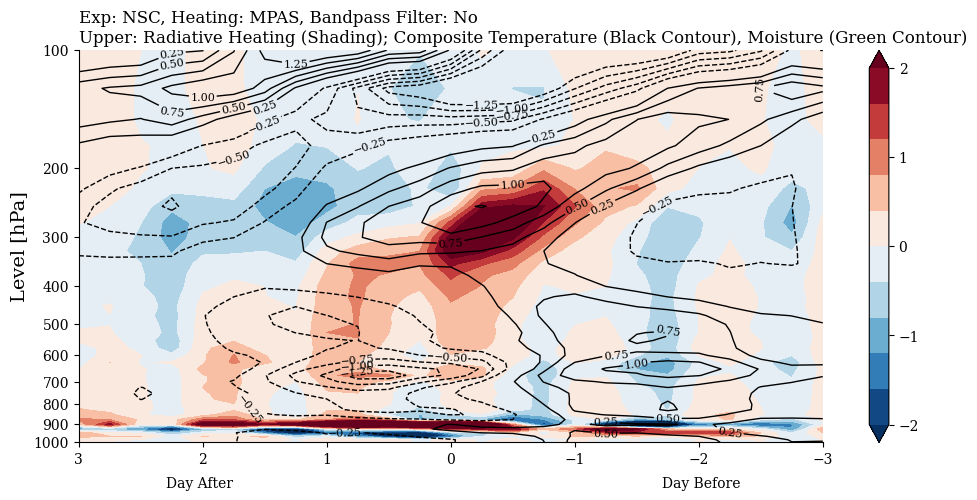

In [13]:
fig = plt.figure(figsize=(12, 7));

# ================= #

ax1 = plt.subplot(gs[0]);

cr1 = plt.contourf(
    time_ticks, dims["lev"],
    data_sel['lw'] + data_sel['sw'],
    cmap="RdBu_r",
    levels=np.linspace(-2, 2, 11),
    extend="both",
    norm=TwoSlopeNorm(vcenter=0)
);
c1 = ax1.contour(
    time_ticks, dims['lev'], data_sel['t'],
    colors='k',
    linewidths=1,
    levels=[-1.25, -1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1, 1.25]
);

plt.gca().spines["top"].set_visible(False);
plt.gca().spines["right"].set_visible(False);
plt.yscale("log")
ax1.set_xticks(np.linspace(-3, 3, 7));
ax1.set_yticks(np.linspace(1000, 100, 10), np.linspace(1000, 100, 10, dtype=int))
plt.gca().invert_xaxis()
plt.gca().invert_yaxis();
ax1.set_ylabel("Level [hPa]")
ax1.set_title(f'Exp: {exp_name}, Heating: MPAS, Bandpass Filter: No\n\
Upper: Radiative Heating (Shading); Composite Temperature (Black Contour), Moisture (Green Contour)',
fontsize=12, loc='left')

plt.clabel(c1, inline=True, fontsize=8)
cb = plt.colorbar(cr1, ax=ax1)
cb.set_ticks(np.linspace(-2, 2, 5))
plt.text(2.3, 1300, 'Day After')
plt.text(-1.7, 1300, 'Day Before')
plt.savefig(f"/home/b11209013/2024_Research/MPAS/Composite/raw_composite/Raw_comp_image/MPAS_sourced/{exp_name}_qr_raw_comp.png", dpi=300)
plt.show()
plt.close()